# 7.인물사진을 만들어 보자
## 핸드폰의 인물사진모드 구현
    - 화각이 다른 두 렌즈를 사용하여 일반(광각) 렌즈에서 배경 촬영 & 망원렌즈에서 인물을 촬영해 뒷배경을 흐리게 처리 후 적절하게 합성
    
    
### 인물사진 모드에서 사용되는 용어
    얕은 피사계 심도(shallow depth of field) or 셸로우 포커스(shallow focus)
    : 배경을 흐리게 하는 기술(우리나라에서 아웃포커싱)
    
------------

## 학습목표
: 딥러닝을 적용하여 핸드폰 인물 사진 모드를 따라해 보자.

---
## 목차

    1. 들어가며
    2. 셸로우 포커스 만들기 (1) 사진을 준비하자
    3. 셸로우 포커스 만들기 (2) 세그멘테이션으로 사람 분리하기
    4. 셸로우 포커스 만들기 (3) 시맨틱 세그멘테이션 다뤄보기
    5. 셸로우 포커스 만들기 (4) 배경 흐리게 하기
    6. 셸로우 포커스 만들기 (5) 흐린 배경과 원본 영상 합성
    7. 프로젝트: 인물 모드 문제점 찾기
    8. 프로젝트 제출
    
---
## 루브릭
|평가문항|상세기준|
|:-----|:---|
|1. 인물모드 사진을 성공적으로 제작하였다.|아웃포커싱 효과가 적용된 본인의 인물모드 사진과 고양이 사진, 배경전환 크로마키사진을 각각 1장 이상 성공적으로 제작하였다.|
|2. 제작한 인물모드 사진들에서 나타나는 문제점을 정확히 지적하였다.|인물사진에서 발생한 문제점을 정확히 지적한 사진을 제출하였다.|
|3. 인물모드 사진의 문제점을 개선할 수 있는 솔루션을 적절히 제시하였다.|추가적인 depth 정보를 활용하여 semantic segmentation mask의 오류를 보완할 수 있는 좋은 솔루션을 구체적으로 제시하였다.|



---------

## 7.2 셸로우 포커스 만들기 (사진을 준비하자)
### 이미지 세그먼테이션(image segmentation) 기술
: 하나의 이미지에서 배경과 사람을 분리할 수 있음

-> 분리된 배경을 블러(blur) 처리 후 사람 이미지와 다시 합침 => 아웃포커싱 효과를 얻을수 있음

### 후가공 순서
    1. 배경이 사진 준비
    2. 시맨틱 세그멘테이션(Semantic segmentation)으로 피사체(사람)와 배경 분리
    3. 블러링(blurring) 기술로 배경 변경 및 수정
    4. 피사체를 배경에 합성

In [1]:
import os
#urllib는 웹에서 데이터를 다운로드할 때 사용
import urllib
#cv2는 OpenCV 라이브러리로 이미지를 처리하기 위해 필요
import cv2
import numpy as np
#pixellib는 시맨틱 세그멘테이션을 편하게 사용할 수 있는 라이브러리 / 준비된 모델 사용
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt


(1440, 1080, 3)


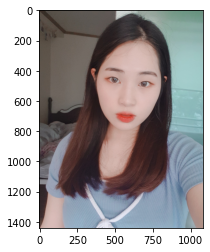

(450, 800, 3)


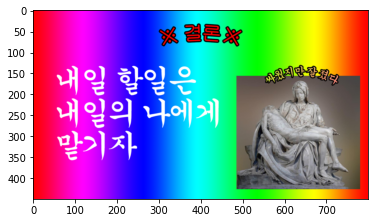

In [2]:

img_path = os.getenv('HOME')+'/aiffel/EX7/human_segmentation/images/ㅋ.jpg'  
img_orig = cv2.imread(img_path) 
back_img_path=os.getenv('HOME')+'/aiffel/EX7/human_segmentation/images/back2.png'  
back_img = cv2.imread(back_img_path) 

print(img_orig.shape)
plt.imshow(cv2.cvtColor(img_orig , cv2.COLOR_BGR2RGB))
plt.show()


print(back_img.shape)
plt.imshow(cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB))
plt.show()

h,w,c=img_orig.shape

In [3]:
'''
2. 제로 패딩(zero padding)+resize() 후 이미지 저장 
    1. 이미지를 불러온다
    2. 배경이미지를 인물 이미지의 크기와 비슷한 크기로 리사이즈 시킨다(비율 유지)
    3. 이미지를 제로 패딩을 활용하여 배경과 크기를 맞춘다.
    4. 패딩된 이미지를 다시 저장시킨다.
'''
# h,w,c=img_orig.shape
# # k=h*2
# # r_back_img= cv2.resize(back_img, (k,h))

# # print(img_orig.shape)
# # plt.imshow(cv2.cvtColor(img_orig , cv2.COLOR_BGR2RGB))
# # plt.show()

# # 패딩으로 이미지 사이즈 변경
# k=((h*2)-w)//2
# r_img_orig =cv2.copyMakeBorder(img_orig,0,0,k,k,cv2.BORDER_CONSTANT,value=[0,0,0])

# A=h*2
# r_back_img= cv2.resize(back_img, (A,h))

# print(r_img_orig.shape)
# cv2.imwrite(img_path,r_img_orig)


# plt.imshow(cv2.cvtColor(r_img_orig , cv2.COLOR_BGR2RGB))
# plt.show()

# print(back_img.shape)
# plt.imshow(cv2.cvtColor(back_img, cv2.COLOR_BGR2RGB))
# plt.show()


# print(r_back_img.shape)
# plt.imshow(cv2.cvtColor(r_back_img, cv2.COLOR_BGR2RGB))
# plt.show()

'\n2. 제로 패딩(zero padding)+resize() 후 이미지 저장 \n    1. 이미지를 불러온다\n    2. 배경이미지를 인물 이미지의 크기와 비슷한 크기로 리사이즈 시킨다(비율 유지)\n    3. 이미지를 제로 패딩을 활용하여 배경과 크기를 맞춘다.\n    4. 패딩된 이미지를 다시 저장시킨다.\n'

## 7.3 셸로우 포커스 만들기(2) 세그멘테이션으로 사람 분리하기
: 배경에만 렌즈 흐림 효과를 주기 위해 이미지에서 사람과 피사체를 분리하는 작업 (누끼따기)

### 이미지 세그멘테이션(image segmentation)
: 이미지에서 픽섹 단위로 관심 객체를 추출하는 방법
 
     <특징>
     - 모든 픽셀에 라벨을 할당하고 같은 라벨을 '공통적인 특징'을 가진다고 가정
         => 공통적 특징은 물리적 의미가 없을수도 있음
         
     <종류>
     1.시맨틱 세그멘테이션(semantic segmentation)
         - 우리가 인식하는 세계처럼 물리적 의미 단위로 인식하는 세그멘테이션
          = 이미지에서 픽셀을 사람, 자동차등의 물리적인 단위로 분류하는 방법
------

## 7.4 셸로우 포커스 만들기(3) 시맨틱 세그멘테이션 다뤄보기
    -DeepLab이라는 세그멘테이션 모델이용 => 성능 조음


In [4]:
# # 모델 다운받기
# # 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/EX7/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# # PixelLib가 제공하는 모델의 url입니다
# model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# # 다운로드를 시작합니다
# urllib.request.urlretrieve(model_url, model_file)

다운로드한 모델을 이용해 PixelLib로 우리가 사용할 세그멘테이션 모델을 생성

In [5]:
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)

In [6]:
# 모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)


PASCAL VOC 데이터의 라벨 종류

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

20개의 클래스중 사람(person)라벨 (15 인덱스)를 가진 영역만 검출해내기

------ 
모델에서 나온 출력값 확인

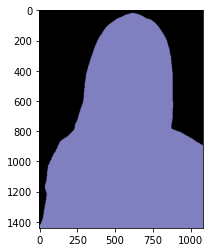

In [8]:
plt.imshow(output)
plt.show()

In [9]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]])}

In [10]:
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

background
person


    - output: 세그멘테이션이 된 결과가 각각 다른 색상으로 담겨 있음
    - segvalues: class_ids와 masks가 담겨있음
    - class_ids를 통해 어떤 물체가 담겨 있는지 알 수 있음

------
물체마다 output에 어떤 색상으로 나타나 있는지만 알아내기

In [11]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

PixelLib에 따르면 위 결과와 같은 색을 클래스마다 사용

---
색상 알아보기

In [12]:
print(colormap[15])

[192 128 128]


다른 물체를 찾아내고 싶다면 colormap[class_id]처럼 찾을 수 있음
    
    %주의사항
     output 이미지 : BGR순서
     colormap : RGB 순서
     
 => 우리가 추출해야하는 색상 값의 순서를 바꾸어주어야함
 

In [13]:
seg_color = (128,128,192)

(1440, 1080)


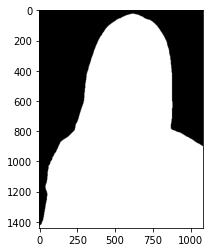

In [14]:
#seg_color로만 이루어진 마스크를 만들기
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()


채널의 정보가 사라짐
 =>물체가 있는 위치는 1(True), 그 외에는 0(False)인 배열이 됨
 
 --------
 원래 이미지와 겹쳐보기 
     
     얼마나 세그멘테이션이 잘되었는지 확인

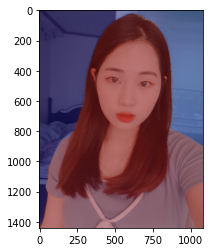

2880
1440
(1440, 2880, 3) (450, 800, 3) (1440, 2880, 3)


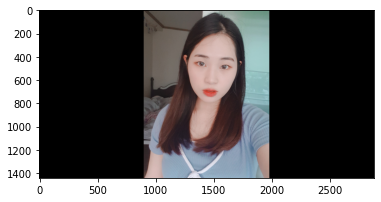

In [15]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

A=2*h
print(A)
r_back_img= cv2.resize(back_img,(A,h))
k=(A-w)//2
print(h)
r_img_orig =cv2.copyMakeBorder(img_orig,0,0,k,k,cv2.BORDER_CONSTANT,value=[0,0,0])
r_img_mask=cv2.copyMakeBorder(img_mask,0,0,k,k,cv2.BORDER_CONSTANT,value=[0,0,0])

print(r_img_orig.shape , back_img.shape,r_img_orig.shape)
plt.imshow(cv2.cvtColor(r_img_orig, cv2.COLOR_BGR2RGB))
plt.show()


In [16]:
# # 3.이미지 자르기

# img_show = img_orig.copy()

# # True과 False인 값을 각각 255과 0으로 바꿔줍니다
# img_mask = seg_map.astype(np.uint8) * 255

# # 255와 0을 적당한 색상으로 바꿔봅니다
# color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# # 원본 이미지와 마스트를 적당히 합쳐봅니다
# # 0.6과 0.4는 두 이미지를 섞는 비율입니다.
# img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

# plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
# plt.show()

# # 배경크기에 맞춰 이미지 자르기
# f_w =(img_orig.shape[1]-w)//2
# b_w = img_orig.shape[1]-f_w
# f_h =(img_orig.shape[0]-h)//3
# b_h =h+f_h
# r_img_orig =img_orig[f_h:b_h,f_w:b_w]
# r_img_mask =img_mask[f_h:b_h,f_w:b_w]

# print(img_orig.shape , back_img.shape,r_img_orig.shape)
# plt.imshow(cv2.cvtColor(r_img_orig, cv2.COLOR_BGR2RGB))
# plt.show()


## 7.5 셸로우 포커스 만들기 (4)배경 흐리게 하기
### blur() 함수 : 배경을 흐리게 해줌

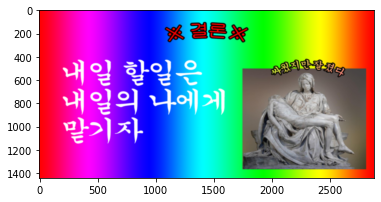

(1440, 2880, 3)


In [17]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(r_back_img, (5,5)) # 흐려지는 정도를 나타냄  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

print(img_orig_blur.shape)

흐려진 이미지에서 세그멘테이션 마스크를 이용해서 배경만 추출

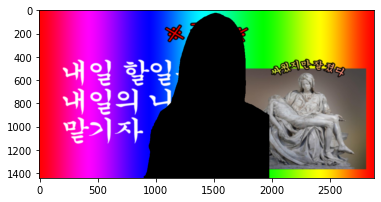

In [18]:
img_mask_color = cv2.cvtColor(r_img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

### bitwise_not 함수를 이용 => 이미지 반전
    원래 마스크 : 배경 0 사람 255
    [bitwise_not 연산 후]
    배경 255 사람 0
    =>0과 어떤 수를 bitwise_and 연산을 해도 0이 되기 때문에 사람이 0인 경우에는 사람이 있던 모든 픽셀이 0이 됩니다. 결국 사람이 사라지게 된다
    
----------

## 7.6 셸로우 포커스 만들기 (5)흐린 배경과 원본 영상 합성

    -세그멘테이션 마스크가 255인 부분만 원본 이미지 값을 가지고 오고 아닌 영역은 블러된 이미지 값을 사용
    -np.where(조건, 참일때, 거짓일때)의 형식의 코드를 사용

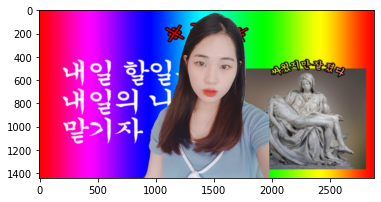

In [19]:
img_concat = np.where(img_mask_color==255, r_img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 7.7 프로젝트 : 인물모드 문제점 찾기

### Step 1. 인물모드 직접 해 보기
    - 셀카를 이용해서 오늘 배운 내용을 수행 (최소 3장이상)
    - 인물이 주인공이 아닌 다른대상도 사용 (시맨틱 세그멘테이션 스탭)
    - 배경을 다른 이미지로 교체해보기
 ## 사진결과 꼭 같이 넣기!!!!
-----------
### Step 2. 사진에서 문제점 찾기
    - 예를 들어 뒤에 걸린 옷이 인물 영역에 포함되어 blur되지 않고 나온다던가 하는 경우등등  문제점을 찾아서 표시하기 (뭐가 이상한지 사진에 글씨 넣기)
    
-----------
### Step 3. 해결 방법을 제안해 보기


### Step 1. 인물모드 직접 해 보기 &Step 2. 사진에서 문제점 찾기


### 전신 점프샷
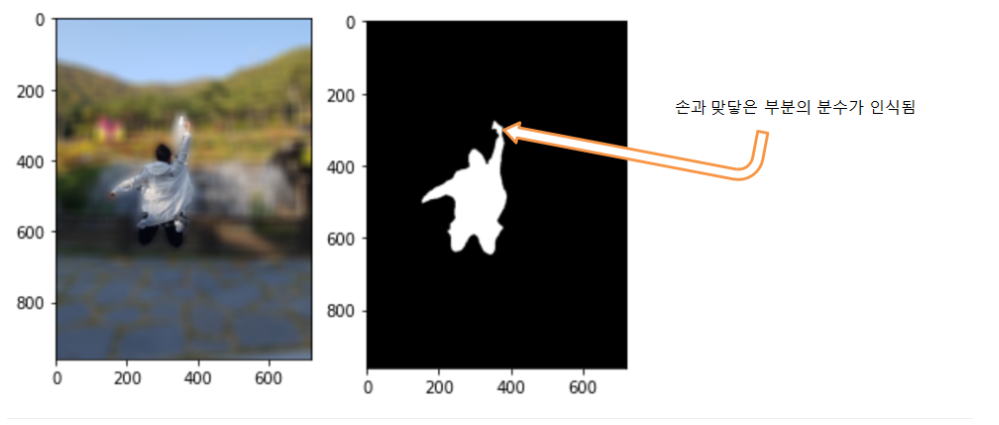

---
### 필터가 사용된 사진
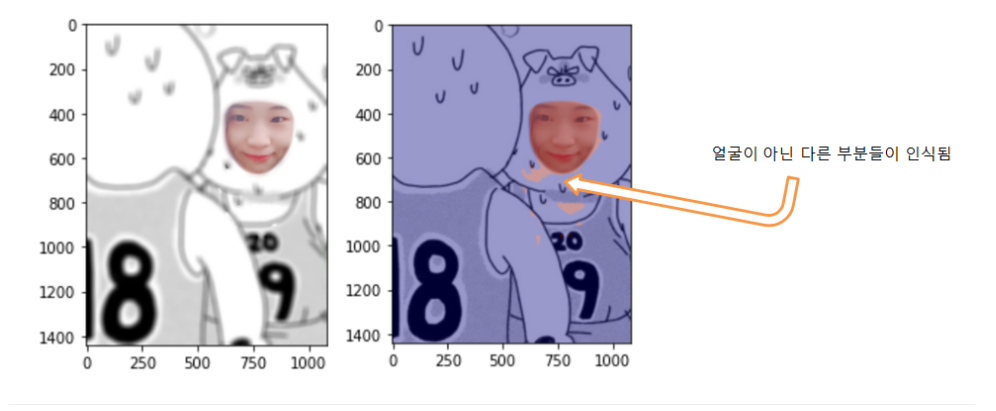

---
### 전신 사진
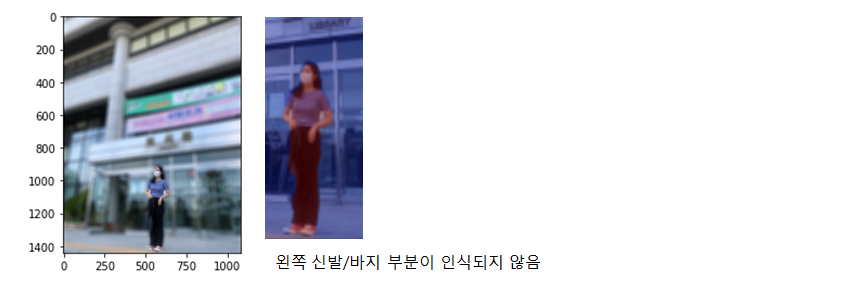

---
### 신체 일부 사진
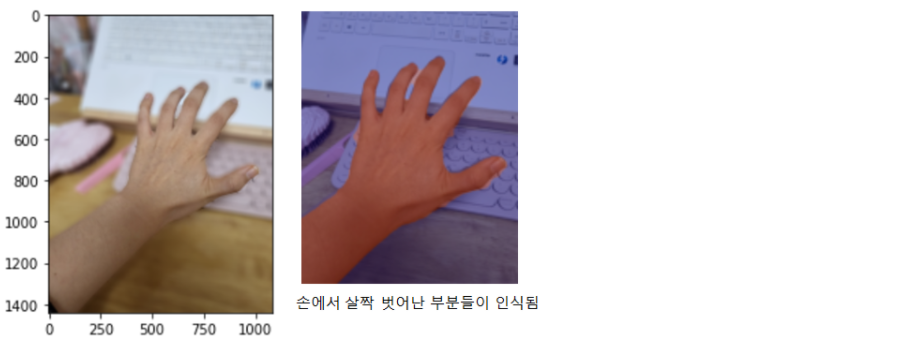

---
### 측면 사진
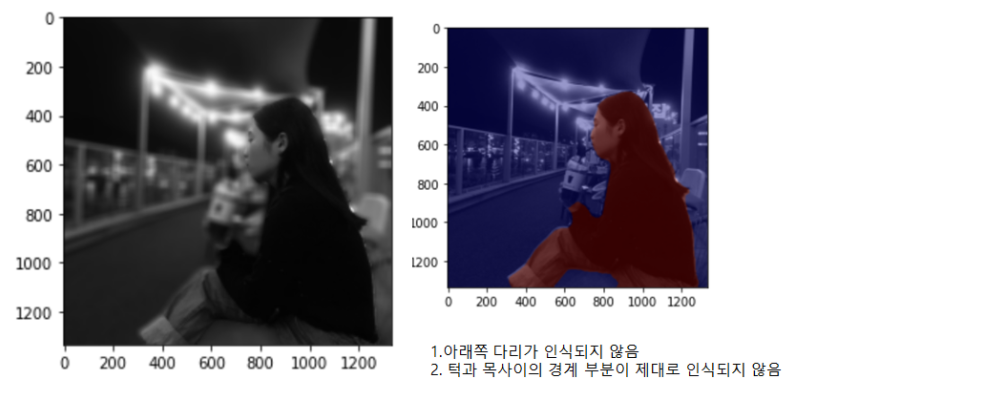

---
### 비교적 인식이 잘된 사진들
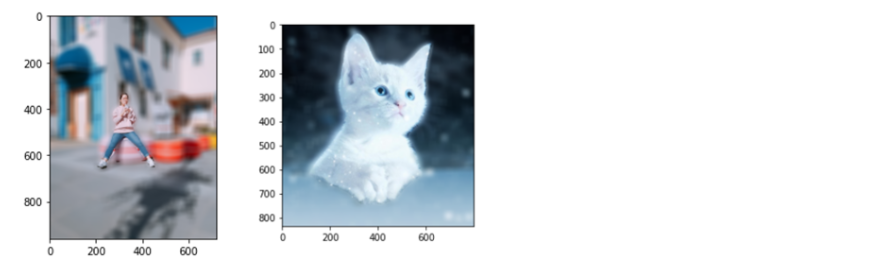
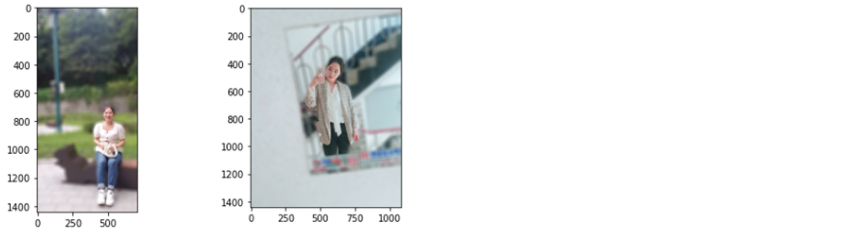

---
### 인식되지 않은 사진들
( 분류되어 있지 않은 대상의 사진, 캐릭터, 필터가 적용된 사진)
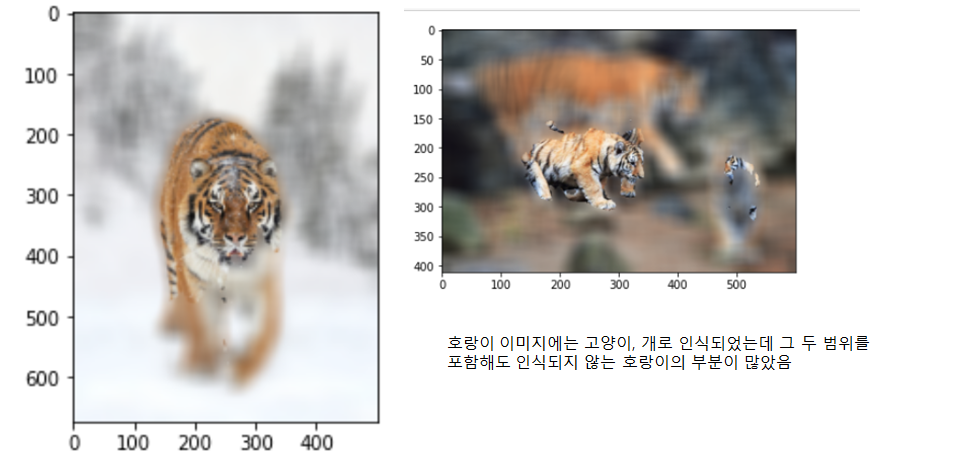
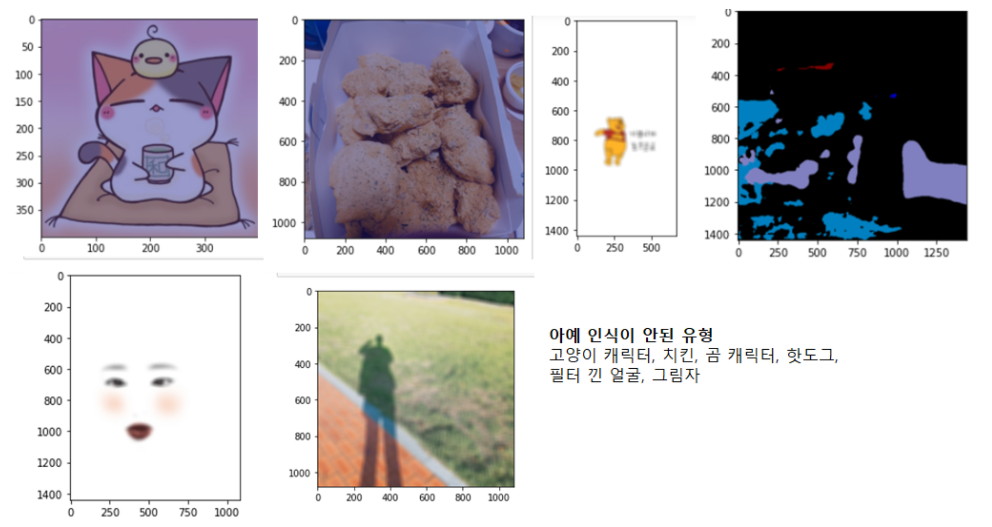


----
### 고양이 이미지
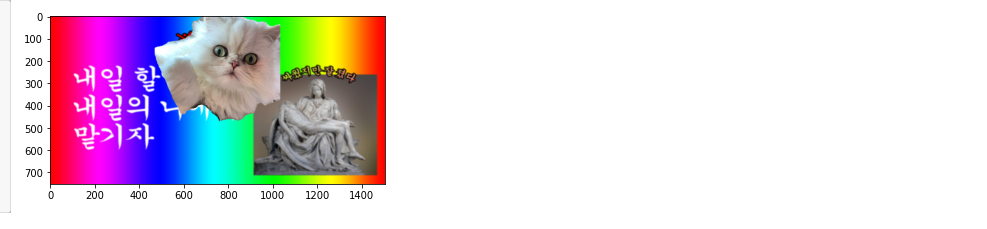

----
### 어두운 이미지 
같은 사진이라도 밝기가 어두울수록 인식이 잘 안되었다.
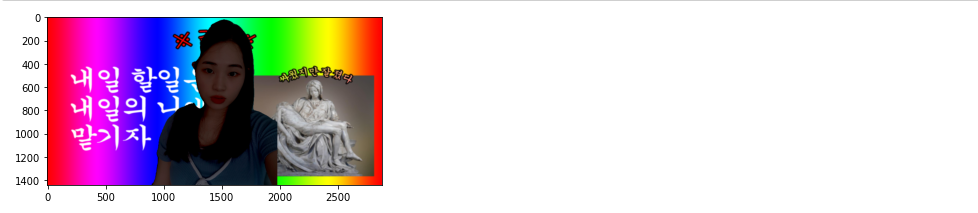



## 배경합성하기

---
### 1. resize()만을 이용한 배경 이미지 합성하기
![python image](3.png)

문제점: 비율이 다른 두개의 이미지를 resize()만을 이용해 크기를 맞춰주니 이미지의 비율이 망가져 원하는 결과가 나오지 않아서 다른 방법을 찾아보았다. 


----

### 2. 제로 패딩(zero padding)+resize() 후 이미지 저장 
: 제로패딩과 resize()를 이용해 배경 이미지와 대상 이미지를 동일한 사이즈로 만들어 저장한후 불러와서 사용하는 방법
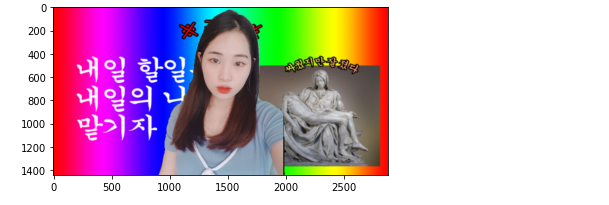

---
### 3.배열 자르기(Slicing) 활용
: 큰 이미지를 작은 이미지에 맞게 자른후에 사용하는 방법
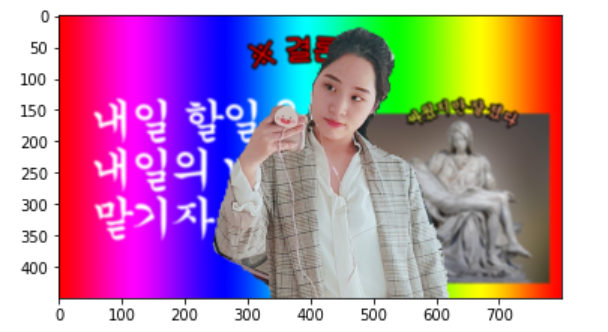

---
### 4. zero padding의 순서 변경
세그멘테이션 이후에 zero padding과 resize 진행
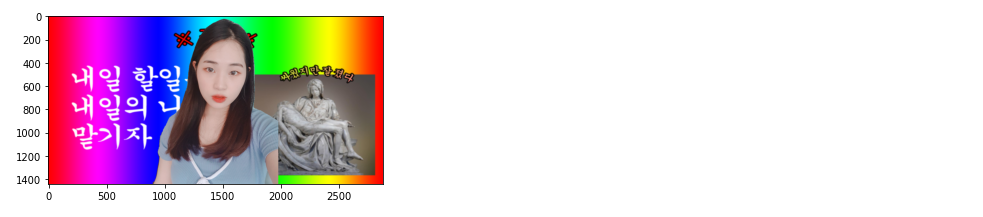

### Step 3. 해결방법 제안해 보기
위 과정을 통해 내가 느낀 세그멘테이션의 한계 이미지가 어둡고 인식 대상과 인접해있는 영역의 인식이 어렵다는 것이었다. 나는 이를 해결하기 위해 사진의 깊이를 추가하는 것을 제안한다. 사진의 깊이를 추가하는 방식을 구체화할 방식은 IR(적외선)센서를 사용하는 것이다. 적외선은 인체에서 방출되기 때문에 가시광선 영역의 영향을 받지 않는다. 그렇기 때문에 어두운 곳에서도 효율적으로 활용될 수 있을 것이며 물체마다 방출하는 적외선의 양이 다르기 때문에 물체를 구분하는 것에 유용할 것이라고 예상된다. 그러나 이러한 IR센서에도 단점이 있는데 이는 비슷한 온도를 방출하는 물체를 구분할수 없다는 것이다. 이 단점을 해결하기 위해서 온도 뿐아니라 인식된 시간도 활용한다면 보다 더 좋은 성능을 구현할 수 있을 것이라고 예상된다.


### 회고
step1에서 배경전환 크로마키사진을 적용하는 부분에서 여러가지 어려움을 겪었다.서로 비슷한 크기의 이미지를 합성할 때는 괜찮았으나 크기와 비율이 다른 두장의 이미지를 합성하려고하니 에러가 발생하였다.그래서 이를 해결하기 위해 총 4개의 방식을 사용해 보았다.
 첫번째로는 resize를 이용하여 배경 이미지를 인물 이미지의 크기에 맞춰 합성했다. 이 방법을 이용하니 사용된 이미지의 비율을 지킬수 없었다.
 두번째로는 합성될 이미지를 불러와 패딩후 저장하는 방식을 이용하였다. 이 방법을 이용하니 세그멘테이션이 인식하는 부분이 더 부정확하였고 패딩시킨후 이미지를 다시 저장하는 방법이여서 원본 이미지 파일이 변형된다는 단점이 있었다.
 세번째는 이미지의 필요한 부분만 배경에 맞게 잘라주는 방식을 이용하였다. 이 방법은 이미지마다 자르는 범위를 다시 지정해주어야 한다는 단점이 있었다.
 마지막 방법은 이미지 합성 직전에 원본이미지와 배경이미지의 크기를 resize와 패딩을 이용하여 맞춰주는 방식을 이용하였다. 위 3개의 방법에 비해 가장 좋은 결과를 얻을 수 있었다.
 
 배경 크로마키 과정을 수행하면서 가장 많이 했던 생각이 '왜 안되지,,'였다. 2번째 방법에서 패딩하고 그 이미지로 세그멘테이션을 진행하려고 했는데 안될때와 3번째 방법에서 이미지를 변경하니 고양이 눈밖에 안보이는 걸 보고 진짜 포기할까도 생각했다.
 
 이 과제를 통해 배운점은 고민한 시간과 횟수는 결과에 비례한다는 점이었다. 처음에는 각 변수가 무엇을 의미하는지도 모르고 padding을 어떻게 적용해야하는 지와 불러온 이미지를 저장하거나 이미지의 크기를 변형하는 방법등도 알지 못했지만 공부와 실습을 반복한 끝에 원하는 결과를 얻을 수 있었다. 또 코드를 적용하는 순서가 중요하다는 것을 다시 한 번느꼈다. 
 마지막으로 배운점은 주피터 노트북에는 'ctrl+z'가 아니라 'z'가 더 소중하다는 것이다. 결과 정리할때 배경 합성 결과 이미지 셀을 지워버렸는데 결과 이미지는 삭제했고 코드는 변경되서 진짜 크로마키 단계를 4번 방법만 정리할 뻔 낼뻔했다.

참고

1. https://www.google.com/search?q=cv2+%ED%8C%8C%EC%9D%BC+%EC%A0%80%EC%9E%A5&rlz=1C1DVJR_koKR849KR849&sxsrf=APq-WBv2CLGCizzi4jGYg-FkC4TeLL78Bw%3A1643357556289&ei=dKXzYcD5EOaRr7wPpZ-EQA&oq=cv2+%ED%8C%8C%EC%9D%BC&gs_lcp=Cgdnd3Mtd2l6EAMYADIFCAAQgAQ6BwgAEEcQsAM6BAgjECc6BAgAEEM6EAgAEIAEEIcCELEDEIMBEBQ6CAgAEIAEELEDOhEILhCABBCxAxCDARDHARDRAzoLCAAQgAQQsQMQgwE6CAguEIAEELEDOgsILhCABBCxAxCDAToFCC4QgAQ6DgguEIAEELEDEMcBEKMCOhEILhCABBCxAxCDARDHARCjAjoECAAQAzoOCC4QgAQQsQMQxwEQ0QM6BwgAELEDEEM6BggAEAoQQzoLCC4QgAQQxwEQ0QM6CggAEIAEEIcCEBQ6BggAEAgQHkoFCDwSATNKBAhBGABKBAhGGABQhwZY0DhguEBoBXACeACAAXaIAeUMkgEENC4xMpgBAKABAbABAMgBCsABAQ&sclient=gws-wiz
2. https://lynmp.com/ko/article/title/markdown-table-om811c9dc5oi
3. https://inbig.github.io/basic/2020/08/02/b0.html
4. https://www.bjultrasonic.com/ko/pros-and-cons-of-infrared-detectors/
5. https://wooono.tistory.com/267
6. https://engineer-mole.tistory.com/7
7. https://can-do.tistory.com/4
8. https://homzzang.com/b/py-313
9. https://ponyozzang.tistory.com/600
10. https://www.geeksforgeeks.org/python-opencv-cv2-copymakeborder-method/